## EDA 및 전처리

In [31]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [32]:
# target은 Churn
data = pd.read_csv('./data/train.csv')

#### 결측치 처리

In [33]:
data.isna().sum()

CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipmentDays           1
AgeHH1    

In [34]:
print(f'data count: {len(data)}')
print(f'nan Max count: {data.isna().sum().max()}')
print(f'duplicated count: {data.duplicated().sum()}')
# # NA의 개수가 데이터 전체 개수에 비해 적으므로 제거하고 사용
data = data.dropna()
# CustomerID는 학습과 관련이 없어 삭제하고 진행
data = data.drop(columns='CustomerID')

data count: 51047
nan Max count: 909
duplicated count: 0


#### EDA

In [39]:
data.Churn.value_counts()

Churn
No     35507
Yes    14245
Name: count, dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

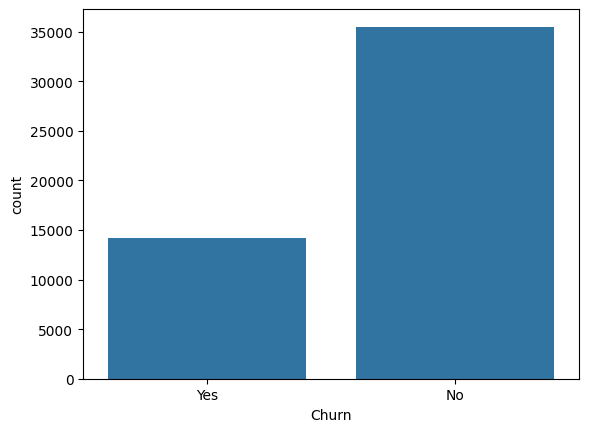

In [41]:
sns.countplot(
    data,
    x='Churn'
)

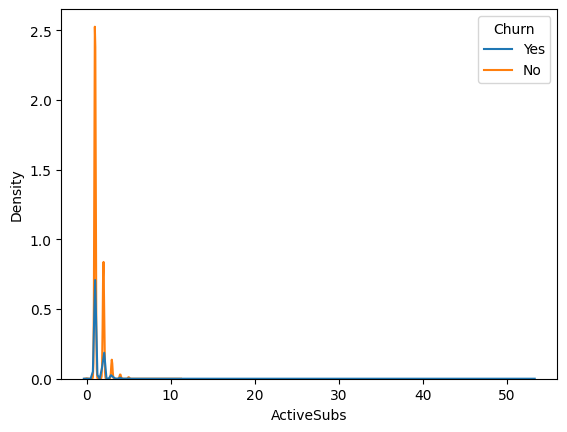

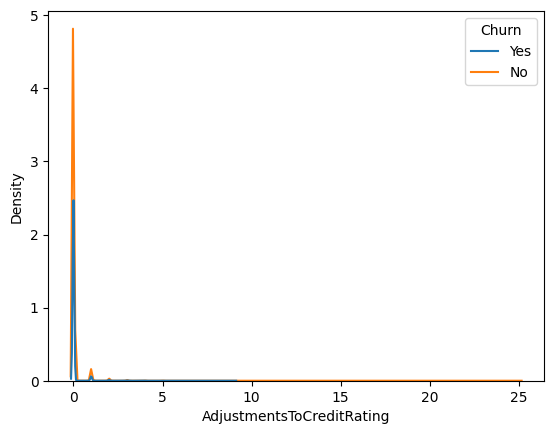

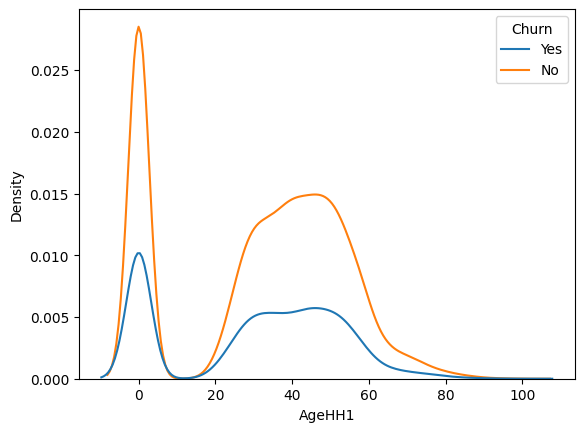

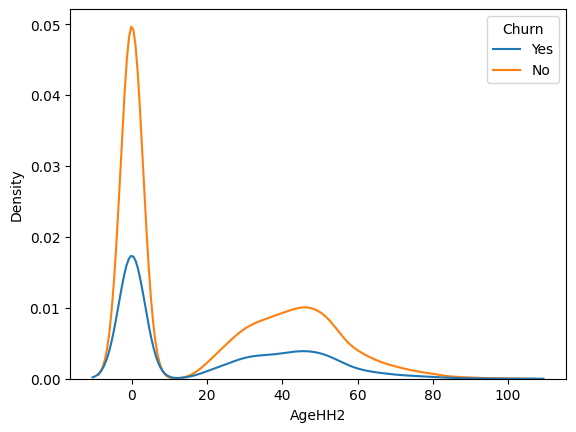

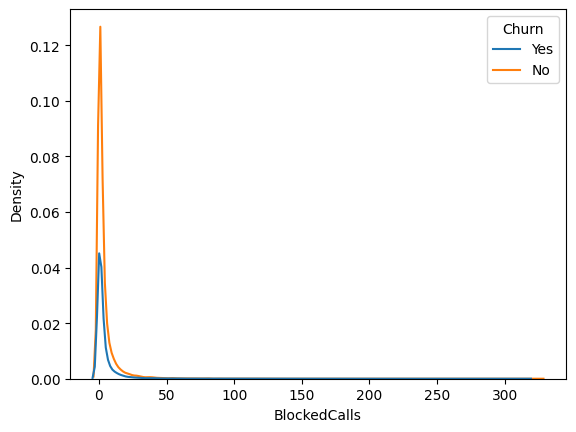

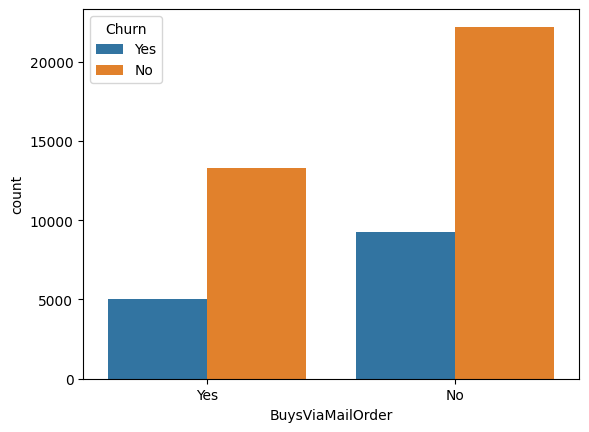

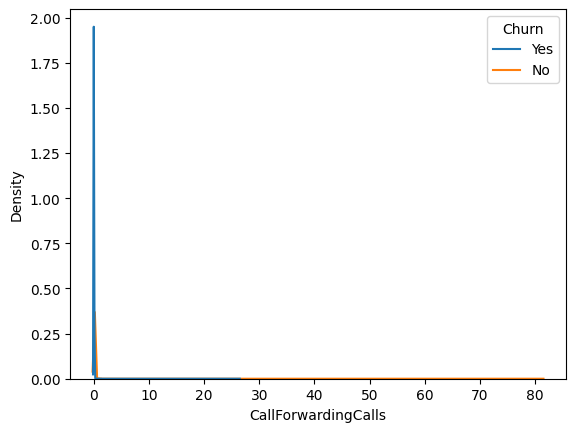

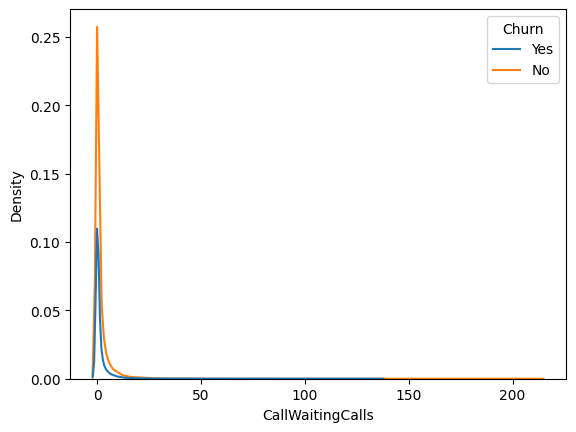

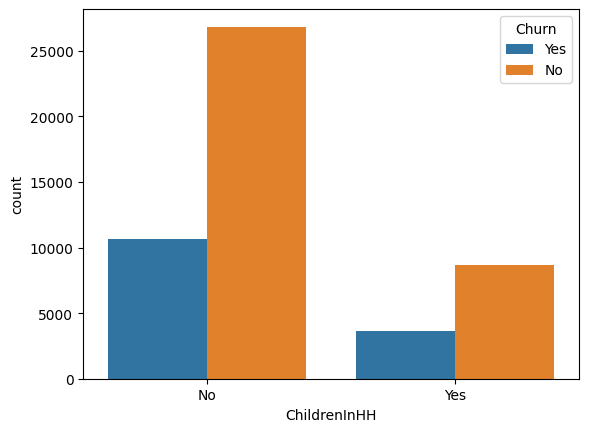

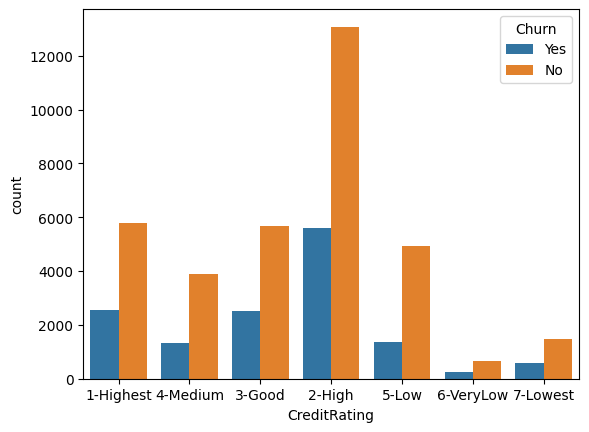

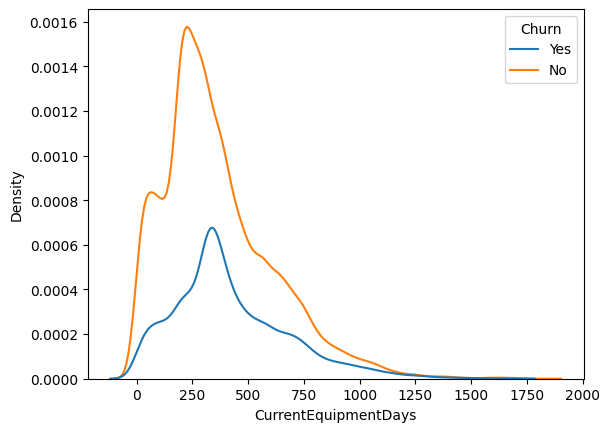

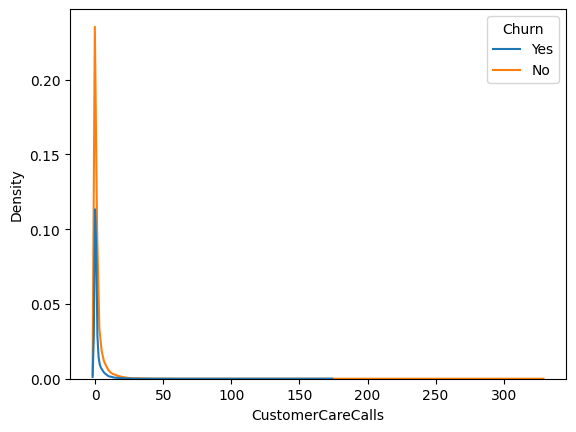

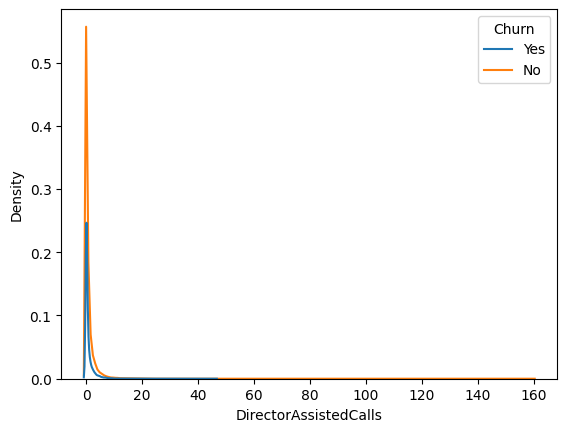

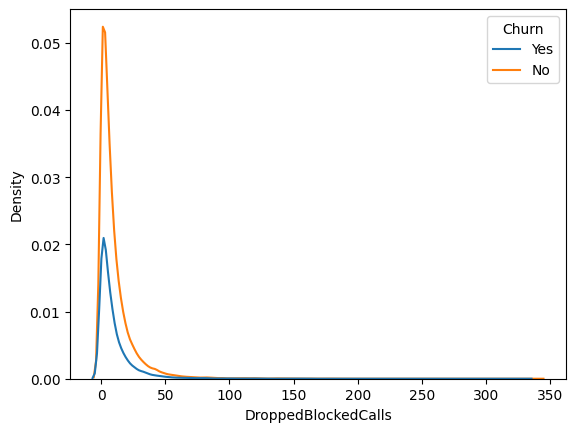

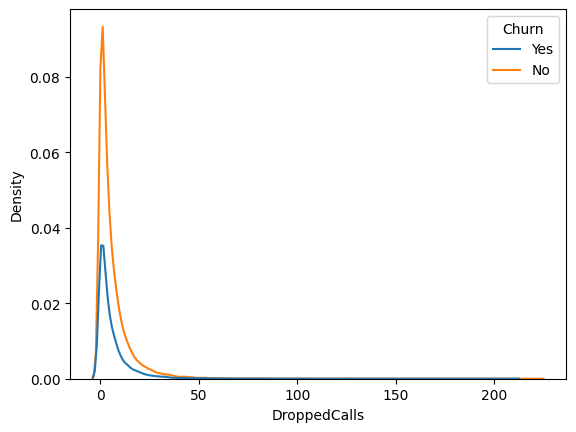

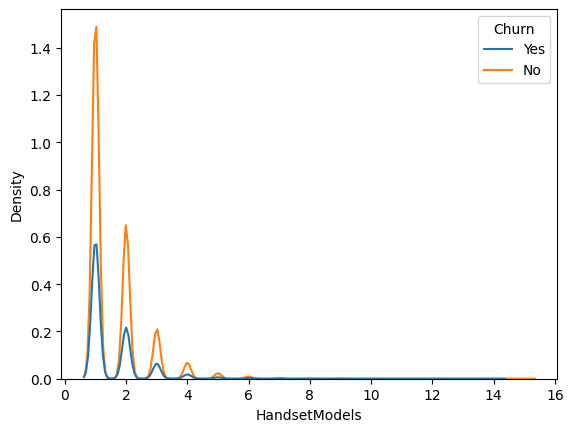

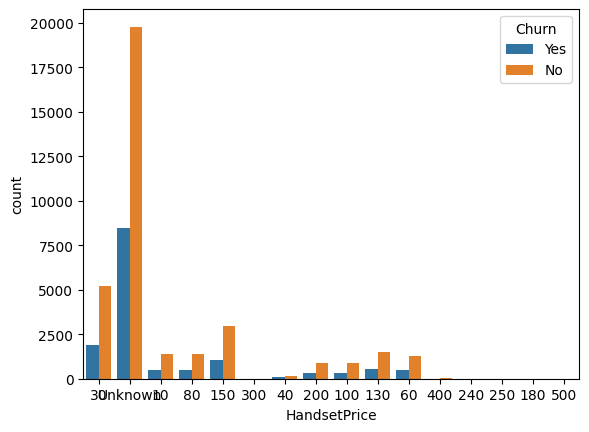

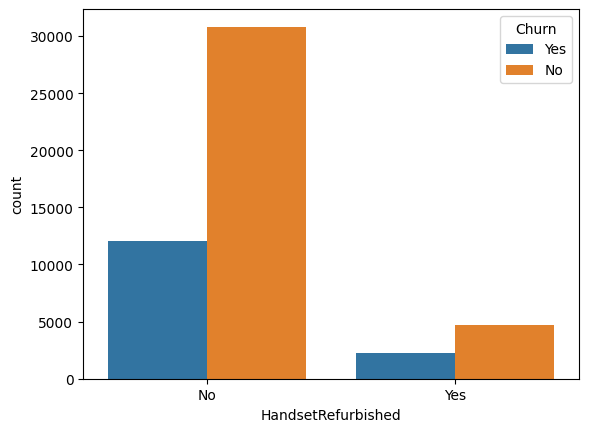

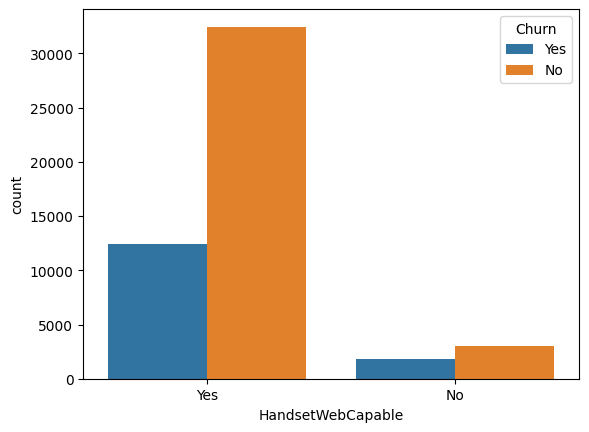

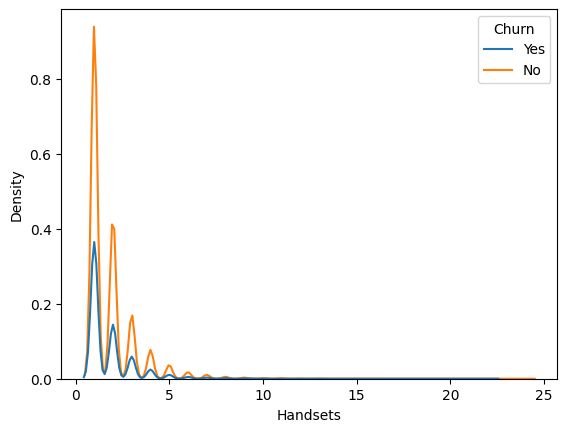

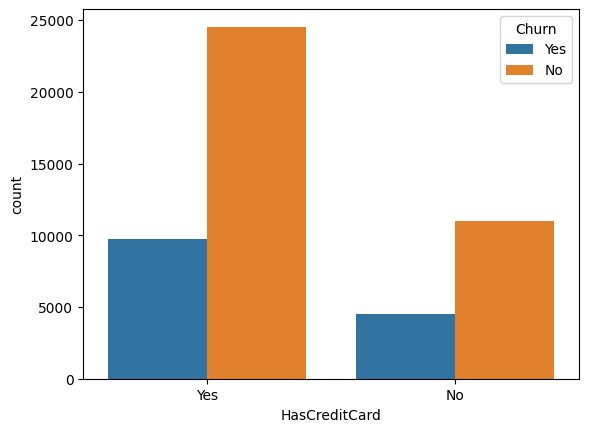

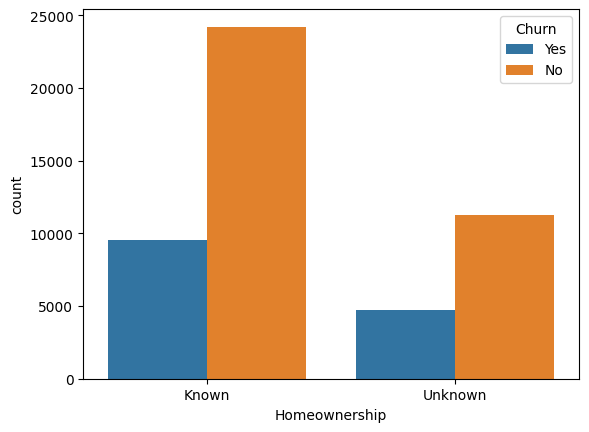

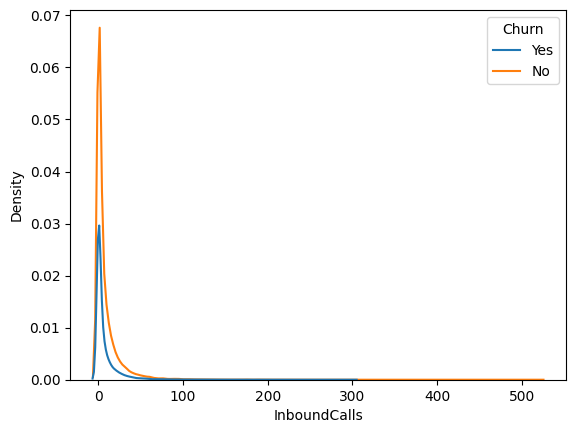

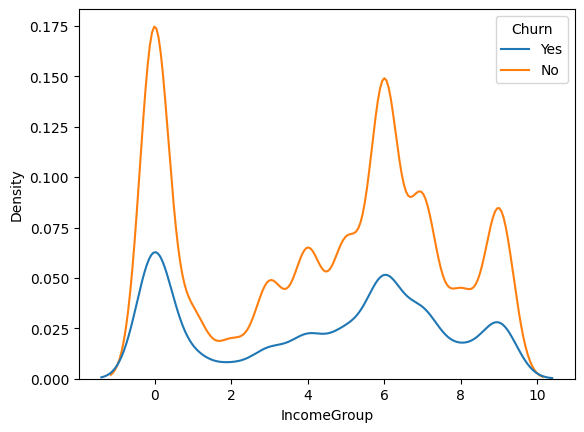

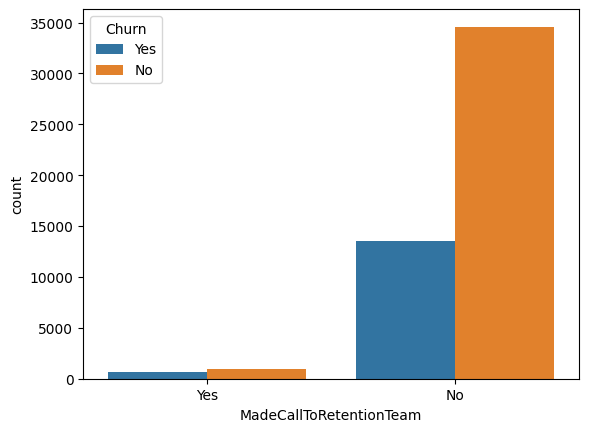

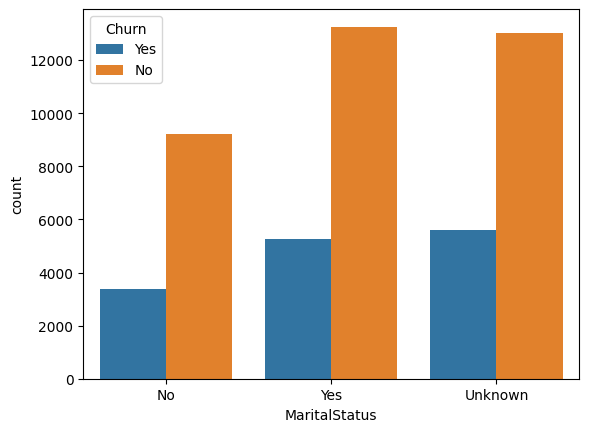

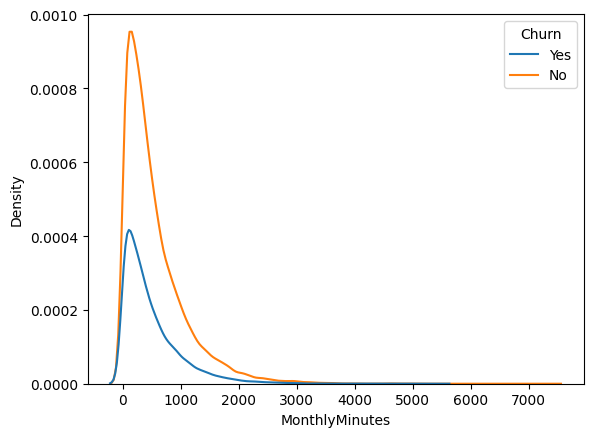

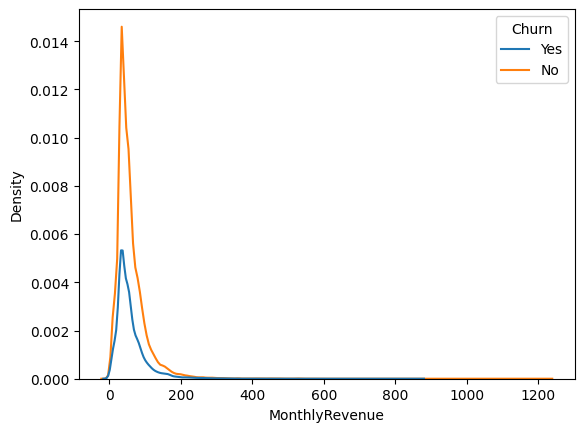

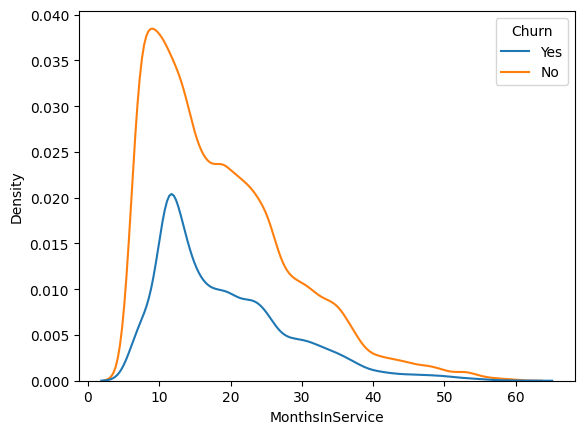

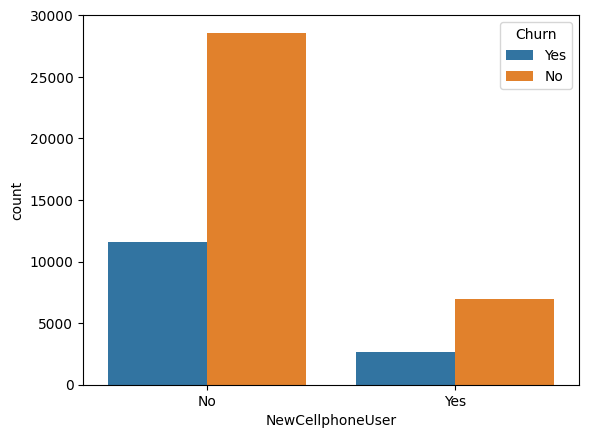

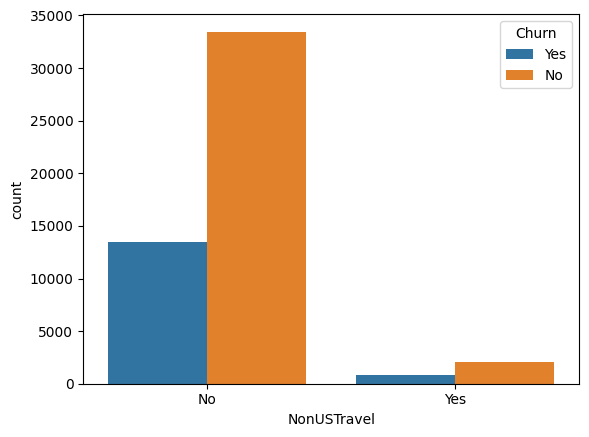

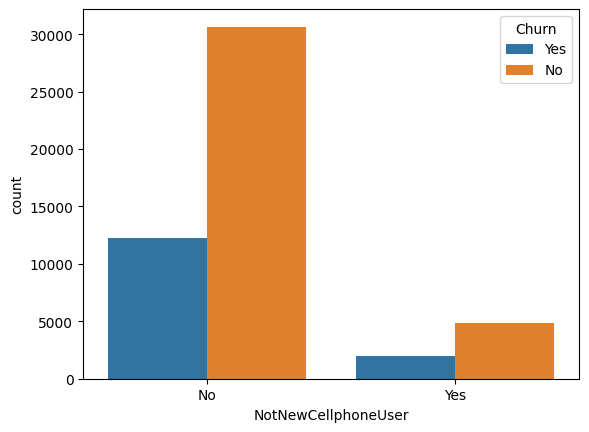

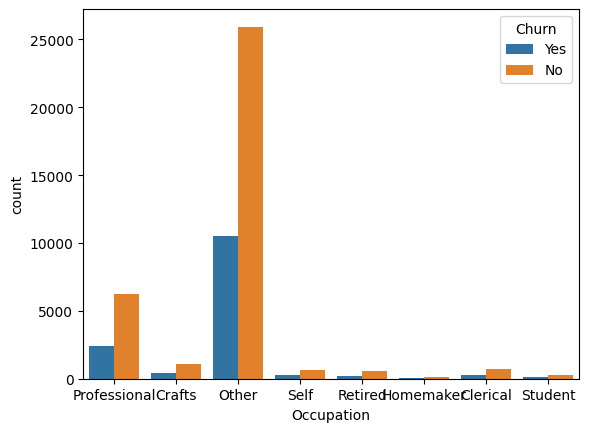

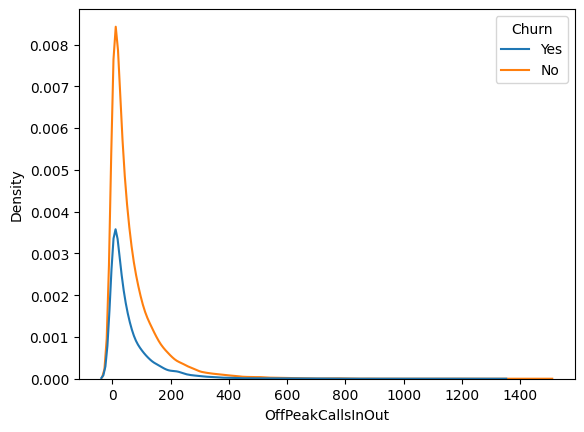

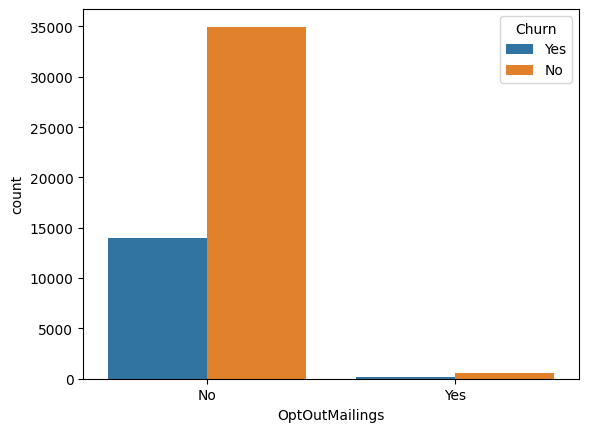

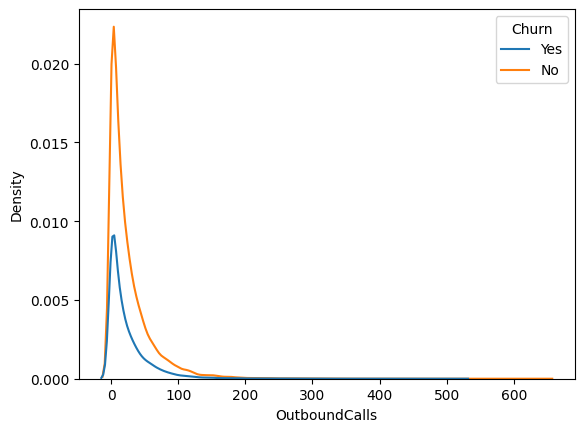

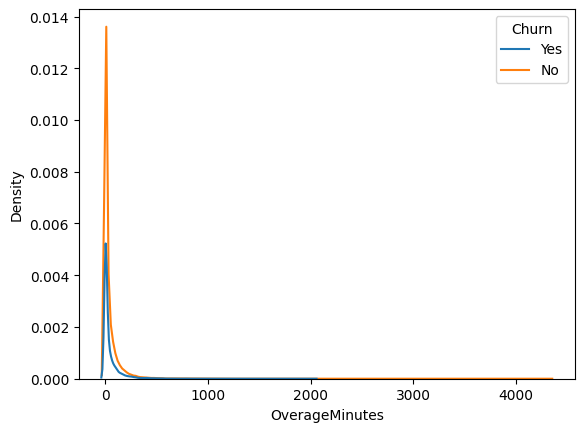

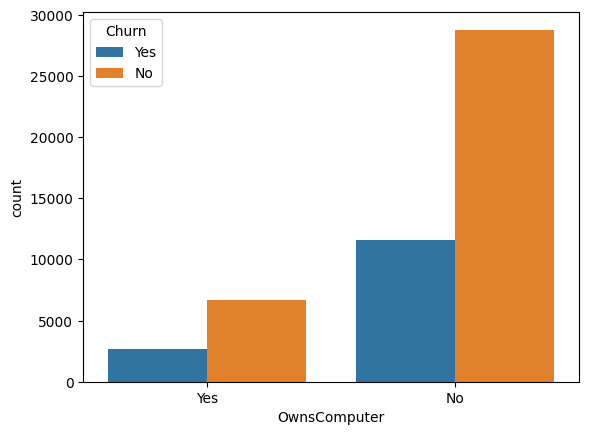

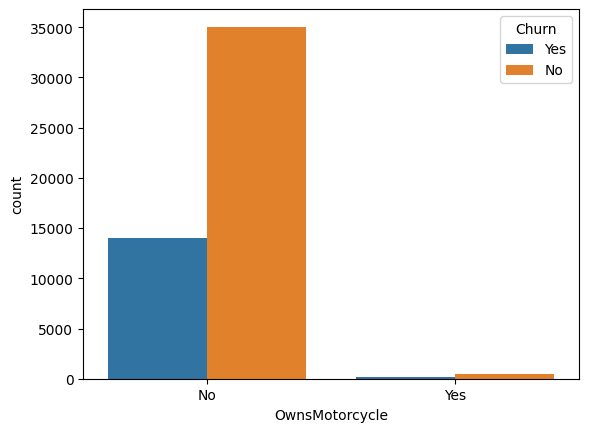

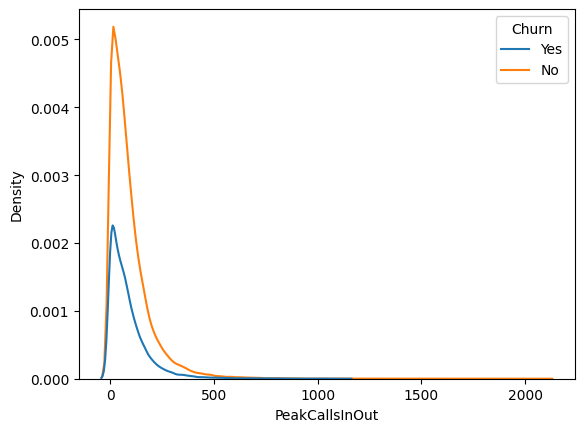

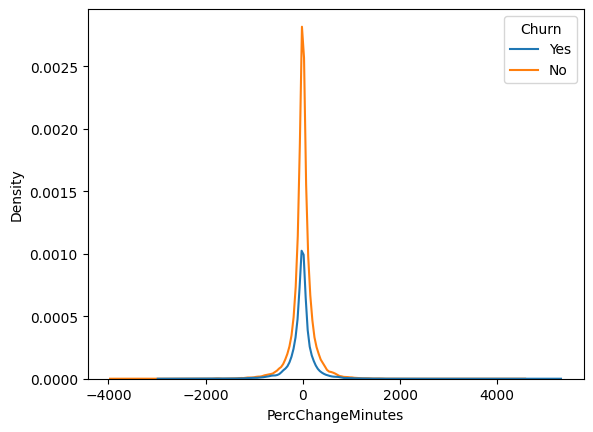

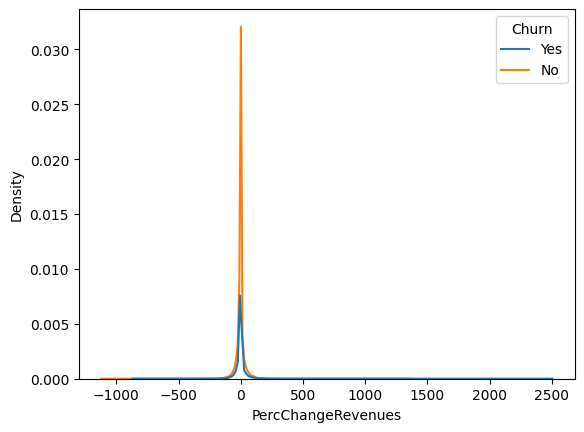

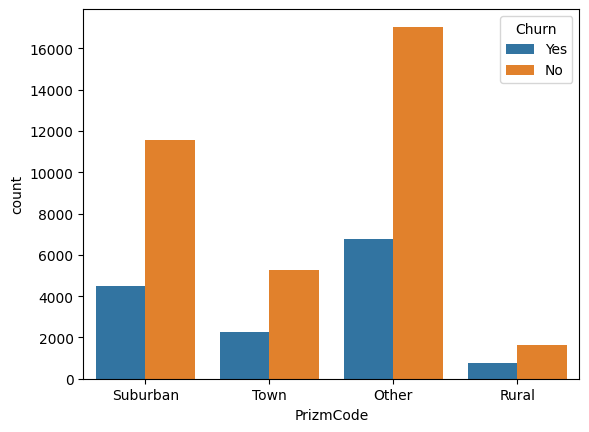

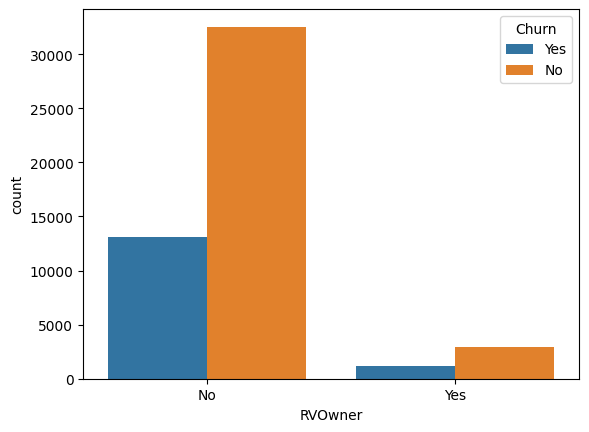

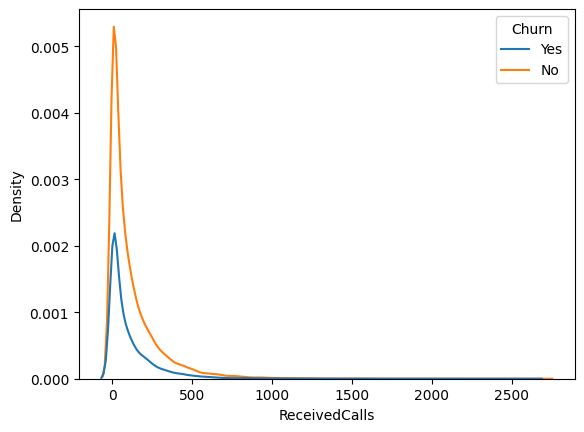

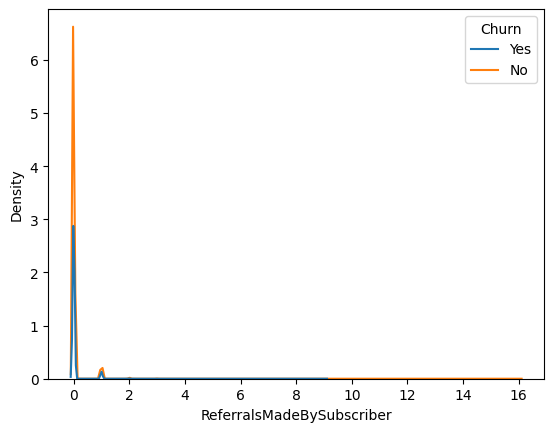

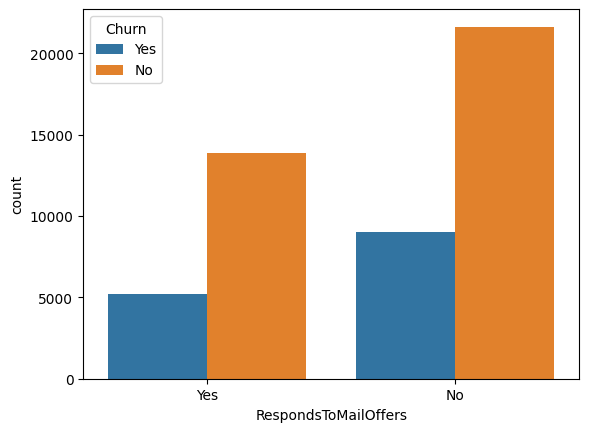

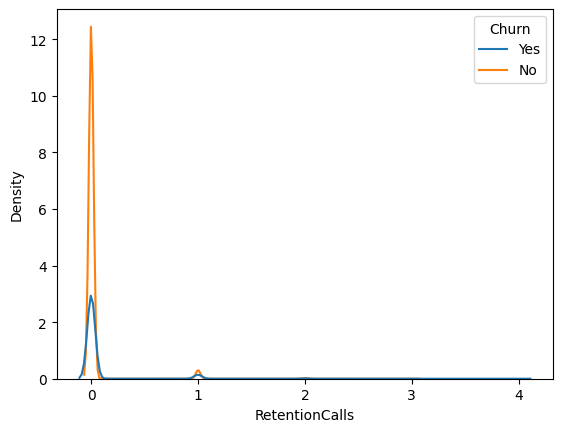

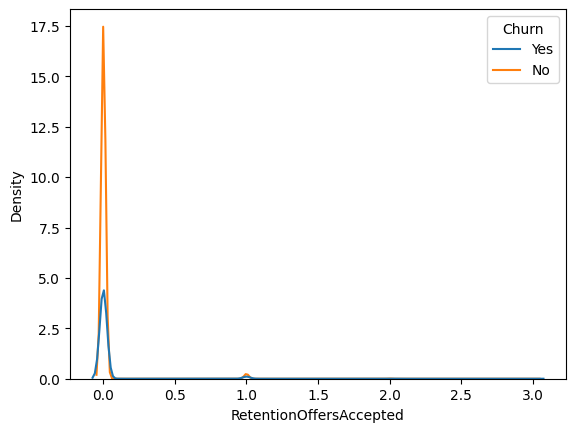

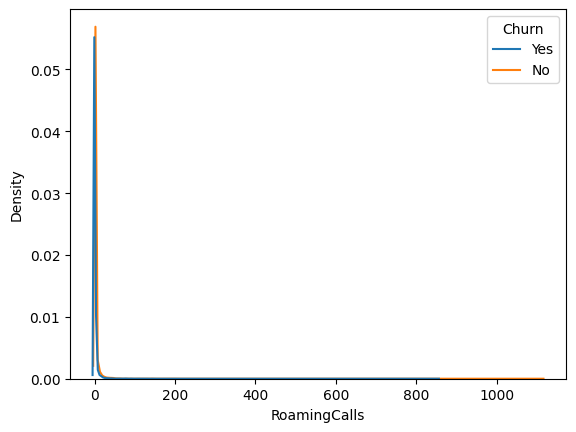

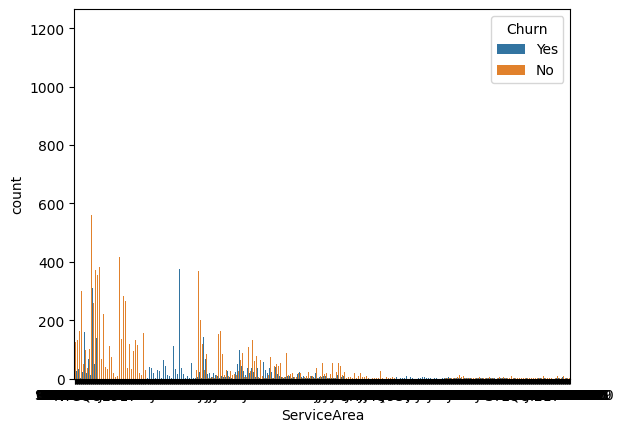

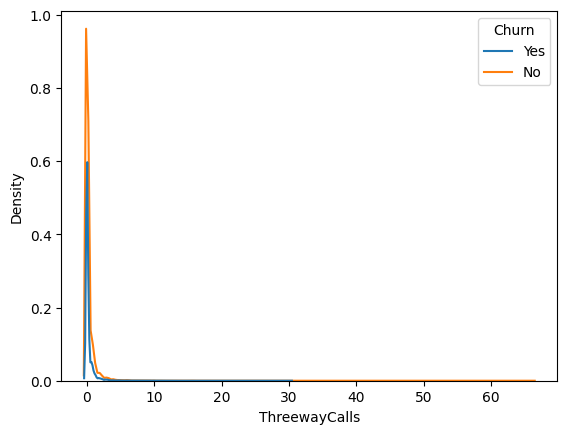

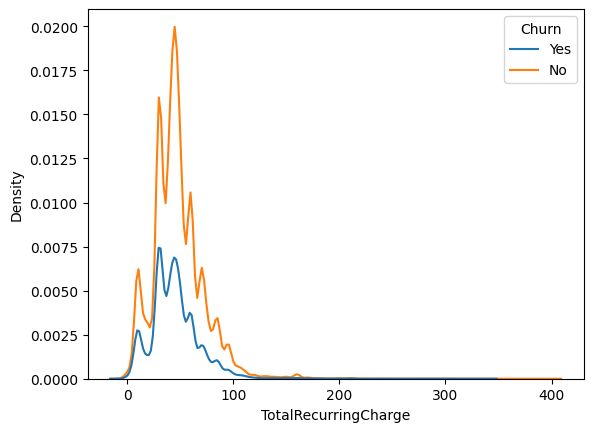

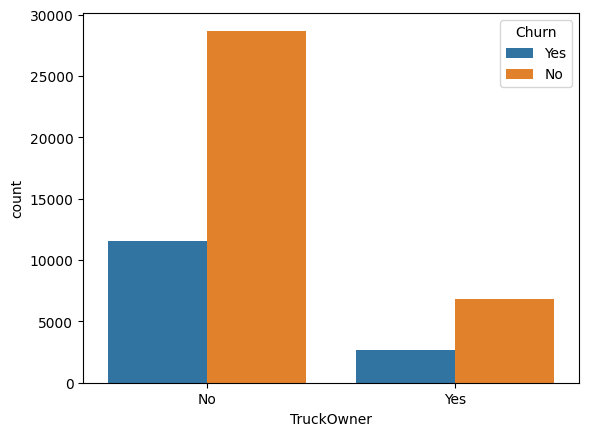

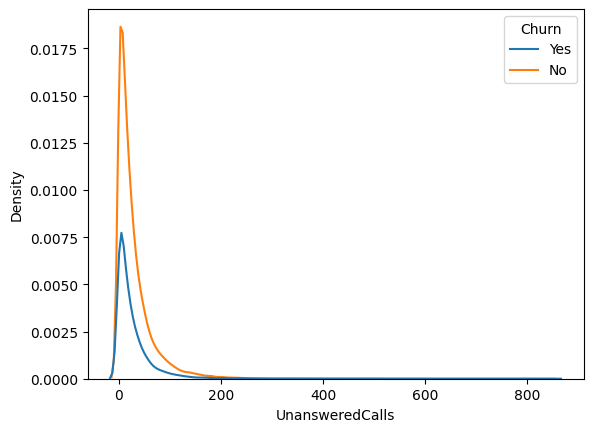

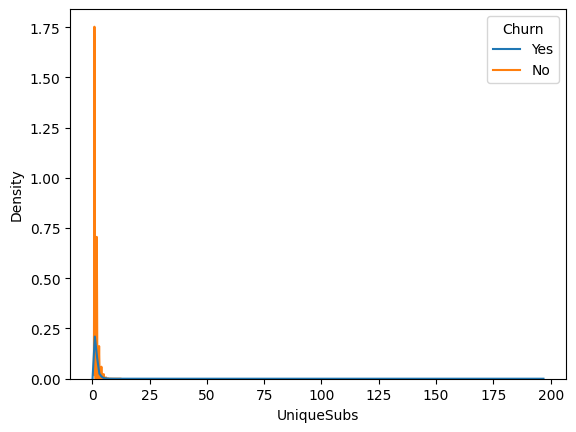

<Figure size 640x480 with 0 Axes>

In [35]:
for col in data.columns.difference(['Churn']):
    if data[col].dtype == object:
        sns.countplot(
            data,
            x=col,
            hue='Churn'
        )
    else:
        sns.kdeplot(
            data,
            x=col,
            hue='Churn'
        )
    plt.show()
    plt.clf()

전체적인 Churn에대한 coutPlot과 kdePlot을 보았을때 유의미하게 구분되는 데이터는 많지 않았다.<br>
그 중에서 유의미한 볼 수 도 있다고 생각되는 컬럼값은 아래와 같다
<br>
HandsetRefurbished<br>
HandsetWebCapable<br>
MadeCallRetentionTeam<br>
NonUSTravel<br>
NewCellphoneUser<br>
NotNewCellphoneUser<br>
OptOutMailings<br>
OwnsMotorcycle<br>
RVOwner<br>
TruckOwner<br>
OwnsComputer<br>

#### Type 변경

In [ ]:
# Churn의 데이터 타입을 str 에서 int형으로 변경
print(f'Churn type: {data.Churn.dtype}')
data.Churn = np.where(data.Churn == "Yes", 1, 0)
print(f'Churn type: {data.Churn.dtype}')

Churn type: object
Churn type: int32


In [ ]:
def convert_object_into_integer(df: pd.DataFrame):
    label_encoders = {}
    for column in df.columns:
        if df.dtypes[column] == object:
            label_encoder = LabelEncoder()
            df[column] = label_encoder.fit_transform(df[column])
            label_encoders.update({column: label_encoder})
    
    return df, label_encoders

In [ ]:
data, _ = convert_object_into_integer(data)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49752 entries, 0 to 51043
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      49752 non-null  int32  
 1   MonthlyRevenue             49752 non-null  float64
 2   MonthlyMinutes             49752 non-null  float64
 3   TotalRecurringCharge       49752 non-null  float64
 4   DirectorAssistedCalls      49752 non-null  float64
 5   OverageMinutes             49752 non-null  float64
 6   RoamingCalls               49752 non-null  float64
 7   PercChangeMinutes          49752 non-null  float64
 8   PercChangeRevenues         49752 non-null  float64
 9   DroppedCalls               49752 non-null  float64
 10  BlockedCalls               49752 non-null  float64
 11  UnansweredCalls            49752 non-null  float64
 12  CustomerCareCalls          49752 non-null  float64
 13  ThreewayCalls              49752 non-null  float64


In [26]:
corr = data.corr(numeric_only=True)

In [27]:
px.imshow(corr, 
                text_auto=True,  
                aspect="auto"
               )

Heatmap을 통한 결과에서 Churn과 다른Feature들간에 유의미한 상관관계는 보이지 않는것으로 판단됩니다.

In [44]:
35507/(14245 + 35507)

0.7136798520662486

#### 결론


Churn의 비율이 아래와 같고<br>
No     35507<br>
Yes    14245<br>
Churn과 Feature간의 유의미한 관계가 있는 데이터가 없다고 보여지기 때문에 기본적으로 모델을 돌렸을때의 예상결과는 
둘의 비율인 0.71에 근접하는 결과가 나올것 같습니다.<br>